# Import libraries

In [4]:
from __future__ import annotations
from pathlib import Path
import numpy as np
import pandas as pd


import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
# --- Optional: load variables via your existing parser ---
try:
    from scripts.parse_vars import parse_variables
except Exception:  # pragma: no cover
    parse_variables = None


# Load functions

In [5]:
from scripts.parse_vars import parse_variables, load_config
from scripts.helpers import map_to_color
from scripts.create_genos import read_simulated_genotypes, compute_maf, categorize_by_maf, run_r_generation, read_generated_csv, simulate_genotypes
from scripts.create_humans import compute_human_metadata, attach_populations, add_rgb_from_xyz
from scripts.lower_dim import compute_pcs, attach_metadata

In [6]:
PATH_VARS = Path("../../geno_simulation.txt")
R_DIRECTORY = Path("../../rstudio_geno_simulation")

# Random seed for reproducibility of the flip step
RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED)

In [7]:
cfg = load_config(PATH_VARS)
G = int(cfg["G"]); L = int(cfg["L"]); c = int(cfg["c"]); k = int(cfg["k"]); M = float(cfg["M"]);

R_DIRECTORY = Path("../../rstudio_geno_simulation")
R_SCRIPT = "create_geno.R"
# but when building filenames, strip trailing .0

CSV_STEM = "simulated_genotypes_G{G}_L{L}_c{c}_k{k}_M{M}.csv"


In [8]:
very_rare_threshold_L = float(cfg["very_rare_threshold_L"])
very_rare_threshold_H = float(cfg["very_rare_threshold_H"])
rare_threshold_L = float(cfg["rare_threshold_L"])
rare_threshold_H = float(cfg["rare_threshold_H"])
common_threshold_L = float(cfg["common_threshold_L"])
common_threshold_H = float(cfg["common_threshold_H"])

In [9]:
run_r_generation(G, L, c, k, M, R_SCRIPT, R_DIRECTORY)
raw = read_generated_csv(G, L, c, k, M, R_DIRECTORY, CSV_STEM)

In [10]:
humans = attach_populations(n_rows=len(raw), k=k, c=c)

In [11]:
# Ensure genotype-only frame first (keeps original column order)
snp_cols = list(raw.columns)
snps = raw[snp_cols].copy()

In [12]:
snps['populations'] = list(humans['populations'])

# Create Outbred population

In [13]:
F_outbred = 0.0

In [14]:
complete, maf = simulate_genotypes(snps, F_outbred)


In [15]:
humans = compute_human_metadata(humans["populations"], k=k)
humans = add_rgb_from_xyz(humans)

In [16]:
# Sort columns by MAF
# Initialize lists to hold the DataFrames
very_rare_cols = []
rare_cols = []
common_cols = []

# Categorize columns based on allele frequency
for col in complete.columns:
    af_value = float(col.split('_')[2])
    if very_rare_threshold_L < af_value <= very_rare_threshold_H:
        very_rare_cols.append(complete[[col]].rename(columns={col: 'VR_' + col}))
    elif rare_threshold_L < af_value <= rare_threshold_H:
        rare_cols.append(complete[[col]].rename(columns={col: 'R_' + col}))
    elif common_threshold_L < af_value <= common_threshold_H:
        common_cols.append(complete[[col]].rename(columns={col: 'C_' + col}))

# Concatenate all collected DataFrames at once
very_rare = pd.concat(very_rare_cols, axis=1) if very_rare_cols else pd.DataFrame()
rare = pd.concat(rare_cols, axis=1) if rare_cols else pd.DataFrame()
common = pd.concat(common_cols, axis=1) if common_cols else pd.DataFrame()

# Concatenate the final DataFrame
complete = pd.concat([common, rare, very_rare], axis=1)

# Vizualize populations through PCA

In [17]:
PC_complete  = compute_pcs(complete,  prefix="PC")
PC_common    = compute_pcs(common,    prefix="PC")
PC_rare      = compute_pcs(rare,      prefix="PC")
PC_veryrare  = compute_pcs(very_rare, prefix="PC")

# --- Attach metadata in one pass, with index alignment
to_have_columns = ['populations', 'x', 'y', 'population']  # (typo fixed)

PC_complete  = attach_metadata(PC_complete,  humans, to_have_columns)
PC_common    = attach_metadata(PC_common,    humans, to_have_columns)
PC_rare      = attach_metadata(PC_rare,      humans, to_have_columns)
PC_veryrare  = attach_metadata(PC_veryrare,  humans, to_have_columns)


In [18]:
number_of_snps = complete.shape[1]
number_of_individuals = complete.shape[0]

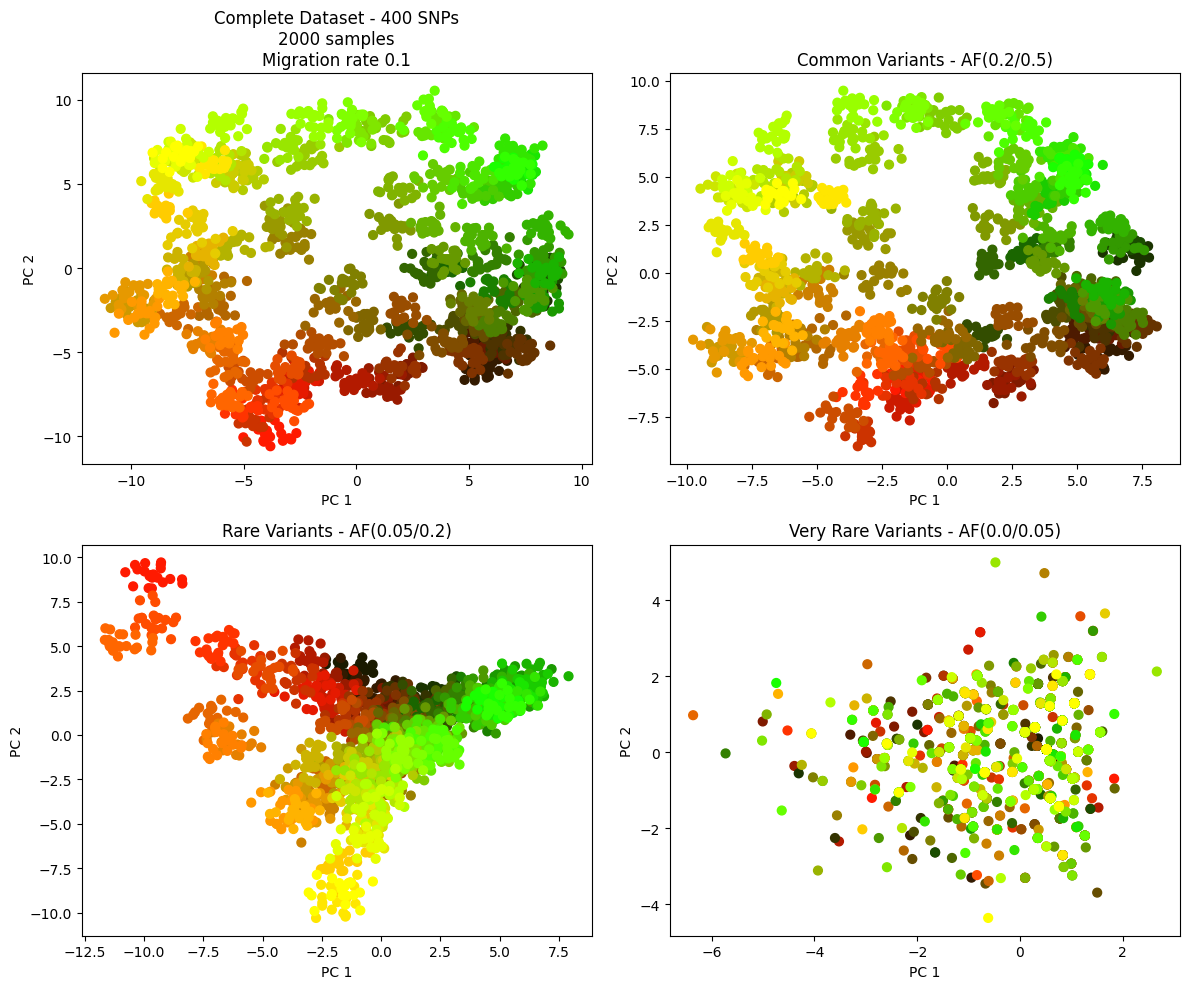

In [19]:
humans['z_outbred'] = humans['z']
# Generate color mapping for the 'humans' DataFrame
colors_outbred = [map_to_color(x, y, z, humans, 'z_outbred') for x, y, z in zip(humans['x'], humans['y'], humans['z_outbred'])]
# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

dataframes = [PC_complete, PC_common, PC_rare, PC_veryrare]
titles = [f"Complete Dataset - {number_of_snps} SNPs\n{number_of_individuals} samples\nMigration rate {M}",
          f"Common Variants - AF({common_threshold_L}/{common_threshold_H})", 
          f"Rare Variants - AF({rare_threshold_L}/{rare_threshold_H})", 
          f"Very Rare Variants - AF({very_rare_threshold_L}/{very_rare_threshold_H})"]

# Iterate through dataframes, axes, and titles
for df, ax, title in zip(dataframes, axes.flatten(), titles):
    # Count the unique values in the 'populations' column
    unique_populations = df['populations'].nunique()
    # Plotting the principal components with colors
    ax.scatter(x=df['PC1'], y=df['PC2'], c=colors_outbred, s=40)
    
    ax.set_title(title)  # Set the title for the current subplot
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.legend([],[], frameon=False) # This hides the legend

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()
plt.close()

In [20]:
path_geno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F_outbred}/genotype"
path_pheno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F_outbred}/phenotype/"
os.makedirs(path_geno, exist_ok = True)
os.makedirs(path_pheno,exist_ok=True)
complete.to_pickle(f"{path_geno}/complete_outbred.pkl")
humans[['populations', 'x','y']].to_pickle(f"{path_pheno}/inbred_humans.pkl")


# Create Inbred population

In [21]:
humans['z_inbred'] = 1

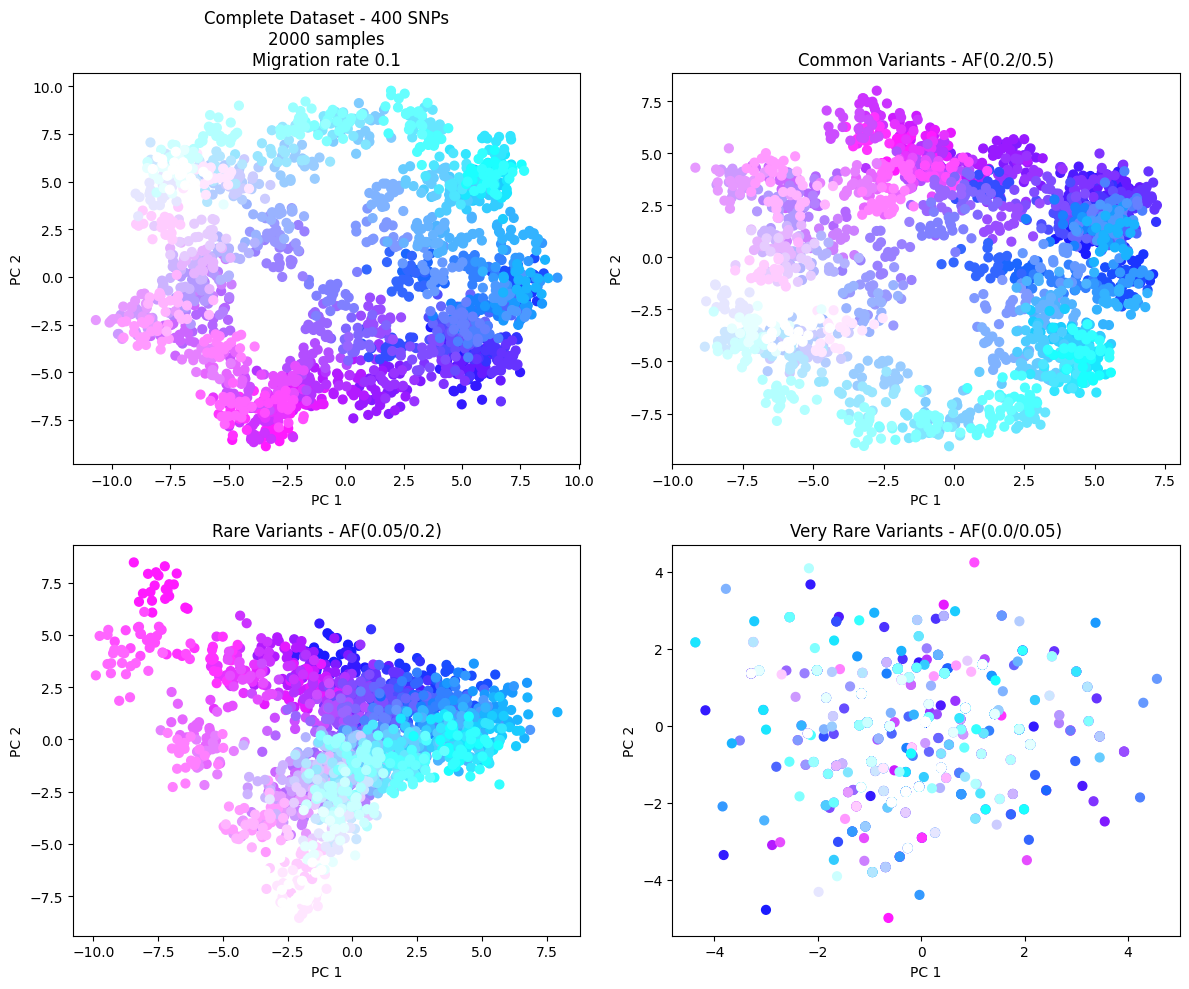

In [22]:
F_inbred = 1.0
complete, maf = simulate_genotypes(snps, F_inbred)
# Sort columns by MAF
# Initialize lists to hold the DataFrames
very_rare_cols = []
rare_cols = []
common_cols = []

# Categorize columns based on allele frequency
for col in complete.columns:
    af_value = float(col.split('_')[2])
    if very_rare_threshold_L < af_value <= very_rare_threshold_H:
        very_rare_cols.append(complete[[col]].rename(columns={col: 'VR_' + col}))
    elif rare_threshold_L < af_value <= rare_threshold_H:
        rare_cols.append(complete[[col]].rename(columns={col: 'R_' + col}))
    elif common_threshold_L < af_value <= common_threshold_H:
        common_cols.append(complete[[col]].rename(columns={col: 'C_' + col}))

# Concatenate all collected DataFrames at once
very_rare = pd.concat(very_rare_cols, axis=1) if very_rare_cols else pd.DataFrame()
rare = pd.concat(rare_cols, axis=1) if rare_cols else pd.DataFrame()
common = pd.concat(common_cols, axis=1) if common_cols else pd.DataFrame()

# Concatenate the final DataFrame
complete = pd.concat([common, rare, very_rare], axis=1)
PC_complete  = compute_pcs(complete,  prefix="PC")
PC_common    = compute_pcs(common,    prefix="PC")
PC_rare      = compute_pcs(rare,      prefix="PC")
PC_veryrare  = compute_pcs(very_rare, prefix="PC")

# --- Attach metadata in one pass, with index alignment
to_have_columns = ['populations', 'x', 'y', 'population']  # (typo fixed)

PC_complete  = attach_metadata(PC_complete,  humans, to_have_columns)
PC_common    = attach_metadata(PC_common,    humans, to_have_columns)
PC_rare      = attach_metadata(PC_rare,      humans, to_have_columns)
PC_veryrare  = attach_metadata(PC_veryrare,  humans, to_have_columns)

number_of_snps = complete.shape[1]
number_of_individuals = complete.shape[0]

# Generate color mapping for the 'humans' DataFrame
colors_inbred = [map_to_color(x, y, z, humans, 'z_inbred') for x, y, z in zip(humans['x'], humans['y'], humans['z_inbred'])]
# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

dataframes = [PC_complete, PC_common, PC_rare, PC_veryrare]
titles = [f"Complete Dataset - {number_of_snps} SNPs\n{number_of_individuals} samples\nMigration rate {M}",
          f"Common Variants - AF({common_threshold_L}/{common_threshold_H})", 
          f"Rare Variants - AF({rare_threshold_L}/{rare_threshold_H})", 
          f"Very Rare Variants - AF({very_rare_threshold_L}/{very_rare_threshold_H})"]

# Iterate through dataframes, axes, and titles
for df, ax, title in zip(dataframes, axes.flatten(), titles):
    # Count the unique values in the 'populations' column
    unique_populations = df['populations'].nunique()
    # Plotting the principal components with colors
    ax.scatter(x=df['PC1'], y=df['PC2'], c=colors_inbred, s=40)
    
    ax.set_title(title)  # Set the title for the current subplot
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.legend([],[], frameon=False) # This hides the legend

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()
plt.close()

In [23]:
path_geno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F_inbred}/genotype"
path_pheno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F_inbred}/phenotype/"
os.makedirs(path_geno, exist_ok = True)
os.makedirs(path_pheno,exist_ok=True)
complete.to_pickle(f"{path_geno}/complete_inbred.pkl")
humans[['populations', 'x','y']].to_pickle(f"{path_pheno}/inbred_humans.pkl")

# Mix individuals

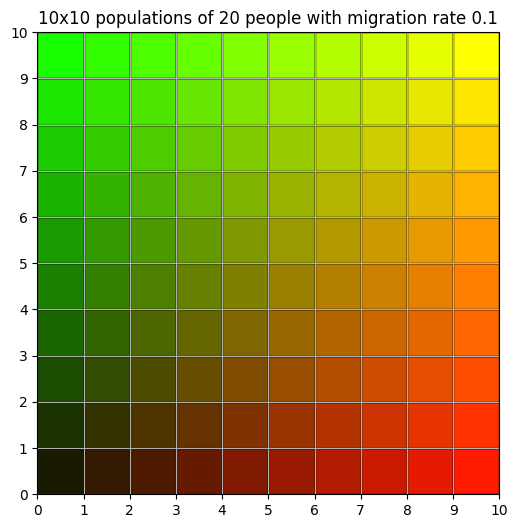

In [24]:
fig, ax = plt.subplots(figsize=(6, 6))

for i in range(k):
    for j in range(k):
        # pick the row for this grid cell
        row = humans[(humans['x'] == i+1) & (humans['y'] == j+1)].iloc[0]
        # compute ONE color for this cell
        cell_color = map_to_color(row['x'], row['y'], row['z_outbred'], humans, 'z_outbred')

        ax.add_patch(plt.Rectangle((i, j), 1, 1, facecolor=cell_color, edgecolor='black'))

ax.set_xlim(0, k)
ax.set_ylim(0, k)
ax.set_aspect('equal')
ax.set_xticks(range(k + 1))
ax.set_yticks(range(k + 1))
ax.grid(True)
plt.title(f"{k}x{k} populations of {c} people with migration rate {M}")
plt.show()


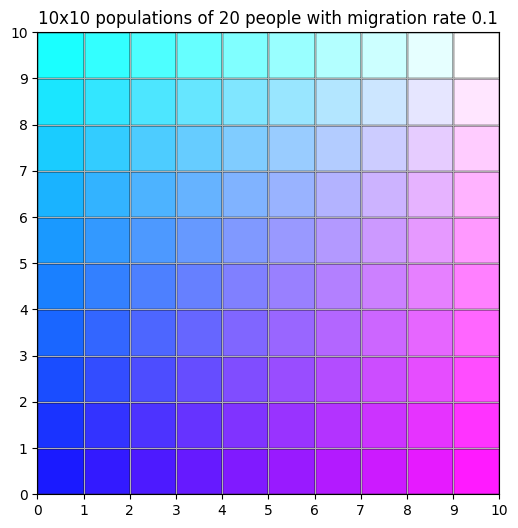

In [25]:
fig, ax = plt.subplots(figsize=(6, 6))

for i in range(k):
    for j in range(k):
        # pick the row for this grid cell
        row = humans[(humans['x'] == i+1) & (humans['y'] == j+1)].iloc[0]
        # compute ONE color for this cell
        cell_color = map_to_color(row['x'], row['y'], row['z_inbred'], humans, 'z_inbred')

        ax.add_patch(plt.Rectangle((i, j), 1, 1, facecolor=cell_color, edgecolor='black'))

ax.set_xlim(0, k)
ax.set_ylim(0, k)
ax.set_aspect('equal')
ax.set_xticks(range(k + 1))
ax.set_yticks(range(k + 1))
ax.grid(True)
plt.title(f"{k}x{k} populations of {c} people with migration rate {M}")
plt.show()


# Mix the populations

In [26]:
pheno = humans[['x','y']].copy()
pheno['01_pheno_linear'] = pheno['x'] + pheno['y']
# Sinusoidal pattern (e.g., across x)
freq_x = 3  # 3 full sine cycles across the x-dimension
freq_y = 2  # 2 full sine cycles across the y-dimension

pheno['02_pheno_sine_x'] = np.round(np.sin(pheno['x'] * freq_x * np.pi / k), 2)
pheno['03_pheno_sine_y'] = np.round(np.sin(pheno['y'] * freq_y * np.pi / k), 2)
# Interaction term (e.g., product of x and y)
pheno['04_pheno_sine_x_y'] = np.round(pheno['02_pheno_sine_x'] + pheno['03_pheno_sine_y'],2)
n = int(k - k//3)
pheno['05_pheno_discrete'] = ((pheno['x'] == n) & (pheno['y'] == n)).astype(int)

from sklearn.preprocessing import MinMaxScaler

# Define a function to scale to [-1, 1]
def scale_minus1_to_1(series):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    return scaler.fit_transform(series.values.reshape(-1, 1)).flatten()

# Apply scaling to all relevant phenotypes
for col in ['01_pheno_linear', '02_pheno_sine_x', '03_pheno_sine_y', '04_pheno_sine_x_y']:
    pheno[col] = scale_minus1_to_1(pheno[col])


In [27]:
scaler = MinMaxScaler()

# Select only columns that start with a digit
env_cols = [col for col in pheno.columns if col[0].isdigit()]

# Scale them in place
pheno[env_cols] = scaler.fit_transform(pheno[env_cols])

In [28]:
humans

,populations,x,y,z,population,r,g,b,z_outbred,z_inbred
0,1,1,1,0,0.01,0.1,0.1,0.0,0,1
1,1,1,1,0,0.01,0.1,0.1,0.0,0,1
2,1,1,1,0,0.01,0.1,0.1,0.0,0,1
3,1,1,1,0,0.01,0.1,0.1,0.0,0,1
4,1,1,1,0,0.01,0.1,0.1,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...
1995,100,10,10,0,1.00,1.0,1.0,0.0,0,1
1996,100,10,10,0,1.00,1.0,1.0,0.0,0,1
1997,100,10,10,0,1.00,1.0,1.0,0.0,0,1
1998,100,10,10,0,1.00,1.0,1.0,0.0,0,1


In [29]:
pheno

,x,y,01_pheno_linear,02_pheno_sine_x,03_pheno_sine_y,04_pheno_sine_x_y,05_pheno_discrete
0,1,1,0.0,0.928205,0.810526,0.870130,0.0
1,1,1,0.0,0.928205,0.810526,0.870130,0.0
2,1,1,0.0,0.928205,0.810526,0.870130,0.0
3,1,1,0.0,0.928205,0.810526,0.870130,0.0
4,1,1,0.0,0.928205,0.810526,0.870130,0.0
...,...,...,...,...,...,...,...
1995,10,10,1.0,0.512821,0.500000,0.506494,0.0
1996,10,10,1.0,0.512821,0.500000,0.506494,0.0
1997,10,10,1.0,0.512821,0.500000,0.506494,0.0
1998,10,10,1.0,0.512821,0.500000,0.506494,0.0


# Mixing linear

In [80]:
env = '02_pheno_sine_x'
humans["mix"] = pheno[env]

In [81]:
humans

,populations,x,y,z,population,r,g,b,z_outbred,z_inbred,mix
0,1,1,1,0,0.01,0.1,0.1,0.0,0,1,0.928205
1,1,1,1,0,0.01,0.1,0.1,0.0,0,1,0.928205
2,1,1,1,0,0.01,0.1,0.1,0.0,0,1,0.928205
3,1,1,1,0,0.01,0.1,0.1,0.0,0,1,0.928205
4,1,1,1,0,0.01,0.1,0.1,0.0,0,1,0.928205
...,...,...,...,...,...,...,...,...,...,...,...
1995,100,10,10,0,1.00,1.0,1.0,0.0,0,1,0.512821
1996,100,10,10,0,1.00,1.0,1.0,0.0,0,1,0.512821
1997,100,10,10,0,1.00,1.0,1.0,0.0,0,1,0.512821
1998,100,10,10,0,1.00,1.0,1.0,0.0,0,1,0.512821


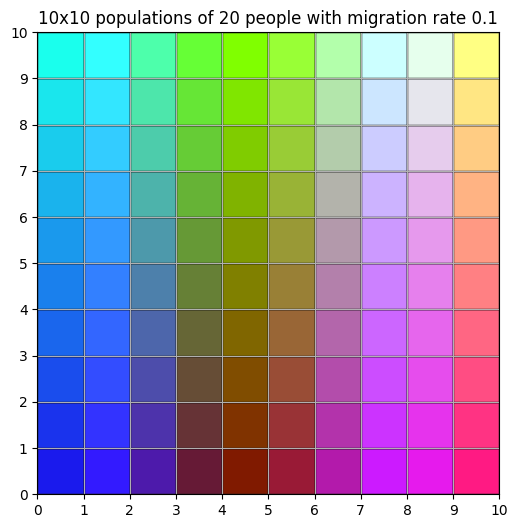

In [82]:
fig, ax = plt.subplots(figsize=(6, 6))

for i in range(k):
    for j in range(k):
        # pick the row for this grid cell
        row = humans[(humans['x'] == i+1) & (humans['y'] == j+1)].iloc[0]
        # compute ONE color for this cell
        cell_color = map_to_color(row['x'], row['y'], row['mix'], humans, 'mix')

        ax.add_patch(plt.Rectangle((i, j), 1, 1, facecolor=cell_color, edgecolor='black'))

ax.set_xlim(0, k)
ax.set_ylim(0, k)
ax.set_aspect('equal')
ax.set_xticks(range(k + 1))
ax.set_yticks(range(k + 1))
ax.grid(True)
plt.title(f"{k}x{k} populations of {c} people with migration rate {M}")
plt.show()


In [83]:
# mix the peoples genotype accordingly

In [84]:
inbred =  pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F_inbred}/genotype/complete_inbred.pkl")
outbred = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F_outbred}/genotype/complete_outbred.pkl")
inbred['pops'] = humans['populations']
outbred['pops'] = humans['populations']


In [85]:
mixed_genotype = []
for pop in inbred['pops'].unique():
    inbred_pop = inbred[inbred['pops'] == pop]
    nr_people_inbred = inbred_pop.shape[0]
    outbred_pop = outbred[outbred['pops'] == pop]
    humans_pop = humans[humans['populations']==pop]
    ratio = humans_pop['mix'].mean()
    inbred_to_select = int(nr_people_inbred*ratio)
    outbred_to_select = int(nr_people_inbred-inbred_to_select)
    sampled_inbred = inbred_pop.sample(n=inbred_to_select, random_state=42)
    sampled_outbred = inbred_pop.sample(n=outbred_to_select, random_state=42)
    combined_df = pd.concat([sampled_inbred, sampled_outbred], ignore_index=True)
    combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)
    mixed_genotype.append(combined_df)

In [86]:
mixed_genotype = pd.concat(mixed_genotype, ignore_index=True)
mixed_genotype = mixed_genotype.drop(columns = ['pops'])

In [87]:
mixed_genotype

,C_1_MAF_0.499,C_2_MAF_0.498,C_3_MAF_0.496,C_4_MAF_0.496,C_5_MAF_0.495,C_6_MAF_0.495,C_7_MAF_0.494,C_8_MAF_0.494,C_9_MAF_0.491,C_10_MAF_0.491,...,VR_391_MAF_0.049,VR_392_MAF_0.049,VR_393_MAF_0.048,VR_394_MAF_0.048,VR_395_MAF_0.047,VR_396_MAF_0.047,VR_397_MAF_0.047,VR_398_MAF_0.045,VR_399_MAF_0.045,VR_400_MAF_0.041
0,-1,-1,1,1,-1,-1,1,-1,-1,1,...,1,1,-1,1,1,1,1,1,1,1
1,-1,-1,1,1,-1,-1,1,-1,-1,1,...,1,1,-1,1,1,1,1,1,1,1
2,1,-1,1,1,-1,-1,1,-1,-1,1,...,1,1,-1,1,1,1,1,1,-1,1
3,-1,-1,1,1,-1,1,1,-1,-1,1,...,1,1,1,1,1,1,1,-1,1,1
4,-1,-1,1,1,-1,-1,1,-1,-1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1,1,-1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,-1,1,1,1
1996,1,1,-1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1997,1,1,-1,1,1,1,1,1,1,1,...,1,1,1,-1,1,1,1,1,1,1
1998,1,-1,-1,1,1,1,-1,1,1,1,...,-1,1,1,1,1,1,1,1,1,1


# Vizualize PCs

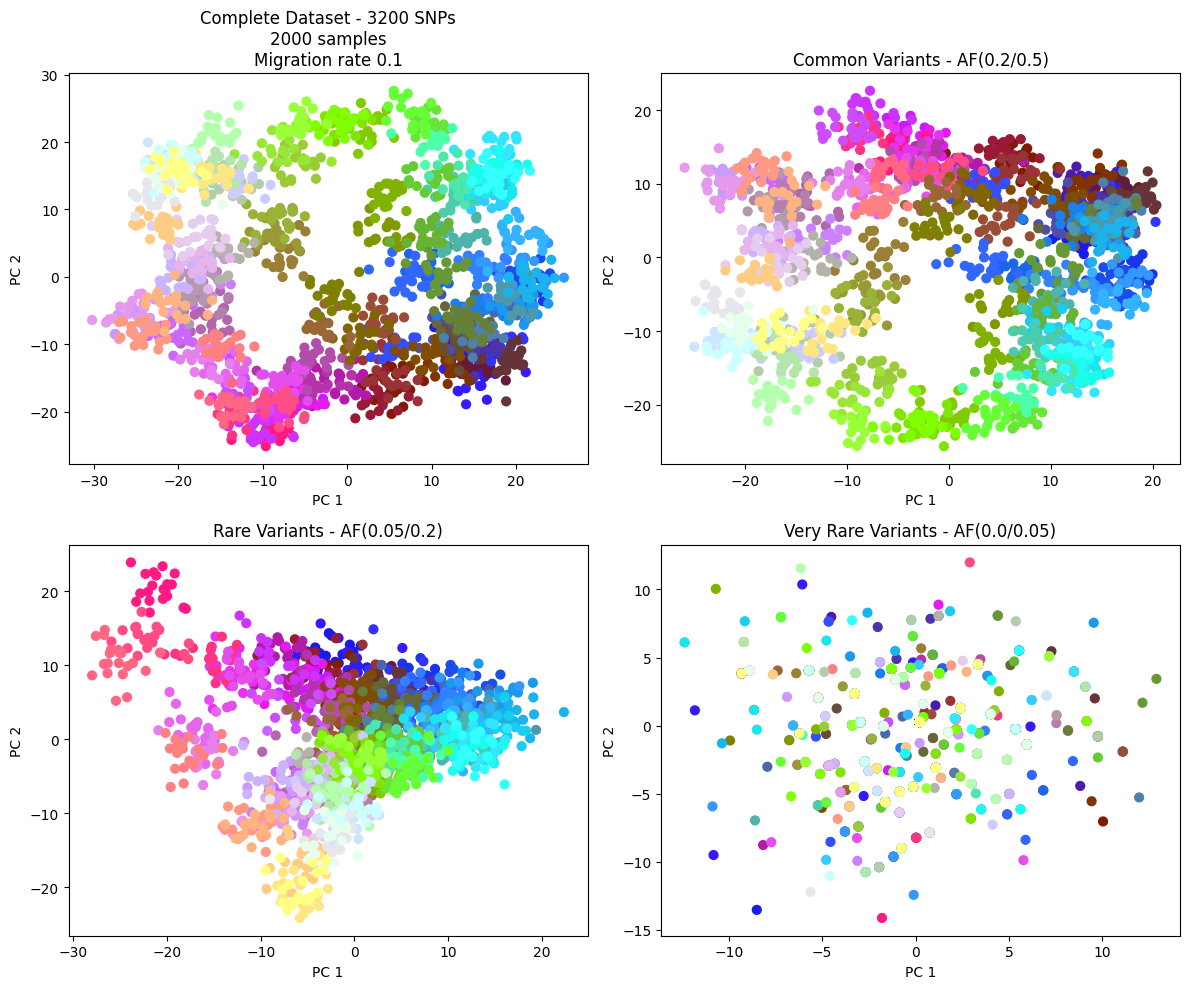

In [88]:

# Categorize columns based on allele frequency
for col in mixed_genotype.columns:
    af_value = float(col.split('_')[3])
    if very_rare_threshold_L < af_value <= very_rare_threshold_H:
        very_rare_cols.append(complete[[col]])
    elif rare_threshold_L < af_value <= rare_threshold_H:
        rare_cols.append(complete[[col]])
    elif common_threshold_L < af_value <= common_threshold_H:
        common_cols.append(complete[[col]])

# Concatenate all collected DataFrames at once
very_rare = pd.concat(very_rare_cols, axis=1) if very_rare_cols else pd.DataFrame()
rare = pd.concat(rare_cols, axis=1) if rare_cols else pd.DataFrame()
common = pd.concat(common_cols, axis=1) if common_cols else pd.DataFrame()

# Concatenate the final DataFrame
complete = pd.concat([common, rare, very_rare], axis=1)
PC_complete  = compute_pcs(complete,  prefix="PC")
PC_common    = compute_pcs(common,    prefix="PC")
PC_rare      = compute_pcs(rare,      prefix="PC")
PC_veryrare  = compute_pcs(very_rare, prefix="PC")

# --- Attach metadata in one pass, with index alignment
to_have_columns = ['populations', 'x', 'y', 'population']  # (typo fixed)

PC_complete  = attach_metadata(PC_complete,  humans, to_have_columns)
PC_common    = attach_metadata(PC_common,    humans, to_have_columns)
PC_rare      = attach_metadata(PC_rare,      humans, to_have_columns)
PC_veryrare  = attach_metadata(PC_veryrare,  humans, to_have_columns)

number_of_snps = complete.shape[1]
number_of_individuals = complete.shape[0]

# Generate color mapping for the 'humans' DataFrame
colors_inbred = [map_to_color(x, y, z, humans, 'mix') for x, y, z in zip(humans['x'], humans['y'], humans['mix'])]
# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

dataframes = [PC_complete, PC_common, PC_rare, PC_veryrare]
titles = [f"Complete Dataset - {number_of_snps} SNPs\n{number_of_individuals} samples\nMigration rate {M}",
          f"Common Variants - AF({common_threshold_L}/{common_threshold_H})", 
          f"Rare Variants - AF({rare_threshold_L}/{rare_threshold_H})", 
          f"Very Rare Variants - AF({very_rare_threshold_L}/{very_rare_threshold_H})"]

# Iterate through dataframes, axes, and titles
for df, ax, title in zip(dataframes, axes.flatten(), titles):
    # Count the unique values in the 'populations' column
    unique_populations = df['populations'].nunique()
    # Plotting the principal components with colors
    ax.scatter(x=df['PC1'], y=df['PC2'], c=colors_inbred, s=40)
    
    ax.set_title(title)  # Set the title for the current subplot
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.legend([],[], frameon=False) # This hides the legend

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()
plt.close()

In [89]:
path_geno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_mixed_{env}/genotype"
path_pheno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F_inbred}/phenotype/"
os.makedirs(path_geno, exist_ok = True)
os.makedirs(path_pheno,exist_ok=True)
complete.to_pickle(f"{path_geno}/complete_inbred.pkl")
humans[['populations', 'x','y']].to_pickle(f"{path_pheno}/inbred_humans.pkl")

'02_pheno_sine_x'

# Save data